# Introduction to prototyping geographically weighted models

`gwlearn` implements generic structures for geographically weighted modelling useful for flexible prototyping of various types of local models. On top, it provides implementation of a subset of specific models for regression and classification tasks.

## Common principle

The principle applied here is the same as in standard geographically weighted regression:

- Each observation in the (spatial) dataset has a local model
- Each local model is fitted on a neighbourhood around its focal observation defined by a set bandwidth
- Each local model uses sample weighting derived from the distance to the focal point and a set kernel function

## Linear regression from scratch

Let's explore the principle by implementing simplified version of linear regression.

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
from geodatasets import data

from gwlearn.base import BaseRegressor

Let's load some data. In this example, you can predict the number of suicides based on other population data in the [Guerry](https://geodacenter.github.io/data-and-lab//Guerry/) dataset.

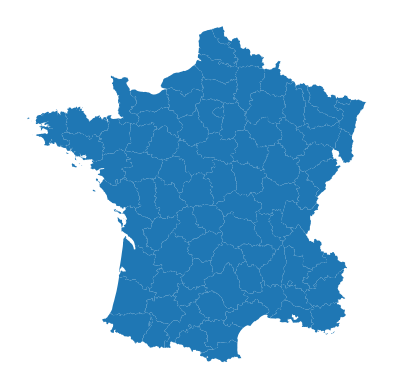

In [37]:
gdf = gpd.read_file(data.geoda.guerry.path)
gdf.plot().set_axis_off()

Let's start with the model class that will be used as individual local models. In this case, `LinearRegression`.

In [3]:
from sklearn.linear_model import LinearRegression

With this, you can use `BaseRegressor` to build geographically weighted version of `LinearRegression`.

In [46]:
gwr = BaseRegressor(
    model=LinearRegression,
    bandwidth=25,
    fixed=False,
    kernel="bisquare",
    geometry=gdf.centroid,
    include_focal=True
)
gwr

,model,<class 'sklea...arRegression'>
,bandwidth,25
,fixed,False
,kernel,'bisquare'
,include_focal,True
,geometry,0 POINT (...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False


The model specification above contains the model class, the bandwidth size and type (adaptive bandwidth with 25 nearest neighbors) and a deifinition of the kernel to be used for sample weights. On top of that, importantly, is also defined `geometry` representing location of observations. Alternatively, you could skip all but model and pass directly a `libpysal.graph.Graph` object capturing spatial neighborhoods and weights directly. Given we are dealing with a linear model, we can also include the focal observation in the training, while still using it for evaluation later.

Fitting the model works as you know it from scikit-learn itself.

In [47]:
gwr.fit(
    X=gdf[['Crm_prp', 'Litercy', 'Donatns', 'Lottery']],
    y=gdf["Suicids"],
)

,model,<class 'sklea...arRegression'>
,bandwidth,25
,fixed,False
,kernel,'bisquare'
,include_focal,True
,geometry,0 POINT (...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False


The basic model contains some information that is common to any generic regressive model.

The first is prediction on focal geometries using the local model built around each (individually). 

In [48]:
gwr.pred_

0     60800.878612
1     14283.306567
2     61918.194878
3     26228.794562
4     15531.652691
          ...     
80    42602.513575
81    19914.708697
82    29128.830096
83    25875.030847
84    19159.068731
Length: 85, dtype: float64

Similarly, you can get residuals based on this prediction.

In [49]:
gwr.resid_

0    -25761.878612
1     -1452.306567
2     52202.805122
3    -11990.794562
4       639.347309
          ...     
80    25360.486425
81     1936.291303
82     4368.169904
83     7153.969153
84    -6370.068731
Length: 85, dtype: float64

Both of which can be plotted and compared to the original `y`.

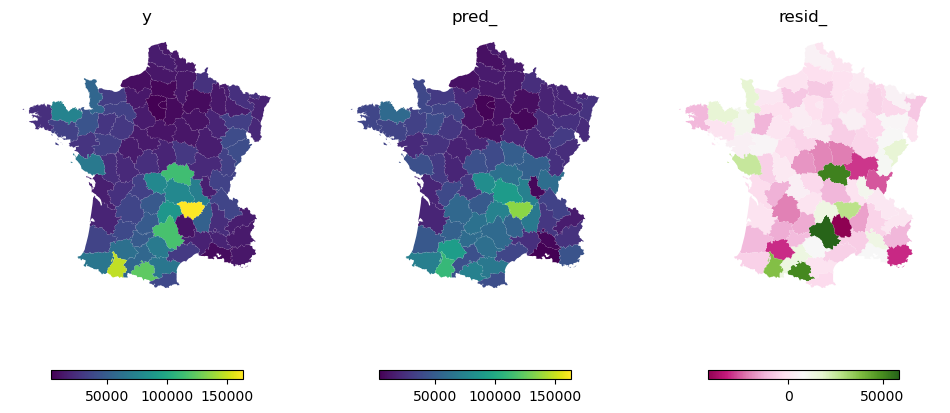

In [50]:
f, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

top = gdf["Suicids"].max()
low = gdf["Suicids"].min()
leg = {"orientation": "horizontal", "shrink": .7}

gdf.plot("Suicids", ax=axs[0], legend=True, legend_kwds=leg)
gdf.plot(gwr.pred_, ax=axs[1], vmin=low, vmax=top, legend=True, legend_kwds=leg)
gdf.plot(gwr.resid_, ax=axs[2], cmap="PiYG", legend=True, legend_kwds=leg)

for ax in axs.flat:
    ax.set_axis_off()

axs[0].set_title('y')
axs[1].set_title('pred_')
axs[2].set_title('resid_');

With regression models, you can furhter retrieve local $R^2$.

In [51]:
gwr.local_r2_

0     0.667045
1     0.587837
2     0.638611
3     0.686119
4     0.719047
        ...   
80    0.506366
81    0.594885
82    0.671242
83    0.165759
84    0.398011
Length: 85, dtype: float64

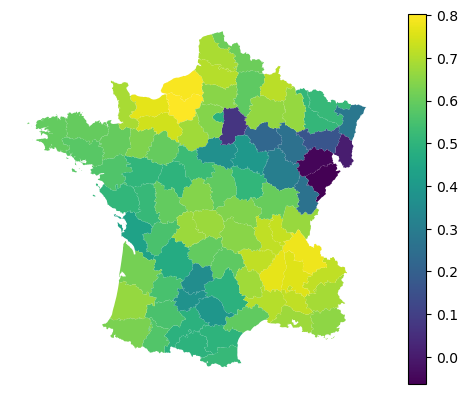

In [54]:
gdf.plot(gwr.local_r2_, legend=True).set_axis_off()

For the model comparison, you can also get information criteria.

In [56]:
gwr.aic_, gwr.aicc_, gwr.bic_

(np.float64(1959.934896362852),
 np.float64(2006.2644970358097),
 np.float64(2044.582781928831))

## Implemented models

While this captures the generic case and can be extrapolated to many other predictive models, it has some limitations. Notably, it is unable to extract information linked to specificities of the selected model. In case of linear regression, we might be interested in fitted coefficients, in case of non-linear models in feature importance and so on.

Consult the rest of the user guide to get an overview of implemented models and other functionality.